In [7]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score 
from dataFrameCovid import DataFrameCovid as dfc
from sklearn.metrics import classification_report
from geraArquivo1 import GeraArquivo as ga

In [8]:
# Monta dataframe com nome dos arquivos
df = dfc.getDf()

d:\DropB\Faculeste\TCC\codigos\dataFrameCovid.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [9]:
# Variáveis de controle
nImagens = len(df)
percentual = 0.8
tamanhoDoLote = 200
epocas = 50
passosPorEpoca = int(nImagens*percentual // tamanhoDoLote)
passosPorValidacao = int(nImagens*(1.0 - percentual) // tamanhoDoLote)
width = 32
height = 32
depth = 3
classes = 2
inputShape = (height, width, depth)
passosPorEpoca, passosPorValidacao

(27, 6)

In [10]:
# gerando dataframes de treinamento e de teste
dfTreinamento = df.sample(frac=0.8, random_state=100) # 70% de treinamento
dfTeste = df[~df['arquivo'].isin(dfTreinamento['arquivo'])]     # 30% de teste

In [11]:
imgGen = ImageDataGenerator(rescale = 1./255, 
                            shear_range=0.25, 
                            zoom_range = 0.25, 
                            horizontal_flip = True)

conjTreinamento = imgGen.flow_from_dataframe(dfTreinamento, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

conjTeste = imgGen.flow_from_dataframe(dfTeste, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

Found 5440 validated image filenames belonging to 2 classes.


Found 1360 validated image filenames belonging to 2 classes.


In [12]:
# Lenet5 - Ajustar imagens para 32 x 32
from modAlexNet import AlexNet
alxClf = AlexNet()
alxClf = alxClf.build(height=height, width=width, depth=3, classes=2)
alxClf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 384)         1

c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
print("Alex Net ***************************************************")
h1 = alxClf.fit(x=conjTreinamento, steps_per_epoch=passosPorEpoca, epochs=epocas, validation_data=conjTeste, validation_steps=passosPorValidacao, verbose=1).history

Alex Net ***************************************************
Epoch 1/50
27/27 [==============================] - 41s 1s/step - loss: 0.6838 - accuracy: 0.5487 - val_loss: 0.6574 - val_accuracy: 0.5675
Epoch 2/50
27/27 [==============================] - 42s 2s/step - loss: 0.6769 - accuracy: 0.5719 - val_loss: 0.6881 - val_accuracy: 0.6175
Epoch 3/50
27/27 [==============================] - 44s 2s/step - loss: 0.6640 - accuracy: 0.6092 - val_loss: 0.6341 - val_accuracy: 0.6483
Epoch 4/50
27/27 [==============================] - 44s 2s/step - loss: 0.6545 - accuracy: 0.6128 - val_loss: 0.6252 - val_accuracy: 0.6767
Epoch 5/50
27/27 [==============================] - 50s 2s/step - loss: 0.6399 - accuracy: 0.6225 - val_loss: 0.5954 - val_accuracy: 0.6775
Epoch 6/50
27/27 [==============================] - 45s 2s/step - loss: 0.6250 - accuracy: 0.6422 - val_loss: 0.7228 - val_accuracy: 0.5033
Epoch 7/50
27/27 [==============================] - 45s 2s/step - loss: 0.6280 - accuracy: 0.6410 -

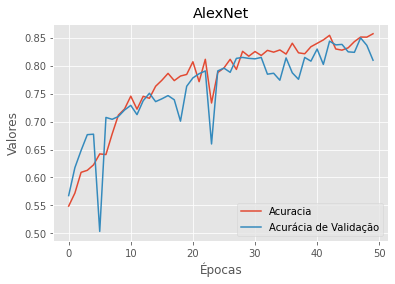

In [14]:
# Gráfico de Acurácia
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), h1["accuracy"], label="Acuracia")
#plt.plot(np.arange(0, epc), h1["loss"], label="Perda")
plt.plot(np.arange(0, epocas), h1["val_accuracy"], label="Acurácia de Validação")
#plt.plot(np.arange(0, epc), h1["val_loss"], label="Perda na Validação")
plt.title("AlexNet")
plt.xlabel("Épocas")
plt.ylabel("Valores")
plt.legend()
plt.show()

In [15]:
prdAlx = alxClf.predict(conjTeste[0][0])
categorias = []
for i in conjTeste[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
predAlexNet = []
for i in prdAlx:
    predAlexNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, predAlexNet, target_names=["Não Covid", "Covid"]))

7/7 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

   Não Covid       0.73      0.93      0.82       104
       Covid       0.90      0.62      0.74        96

    accuracy                           0.79       200
   macro avg       0.81      0.78      0.78       200
weighted avg       0.81      0.79      0.78       200



In [16]:
ga.geraHistorico("arquivos/arqAlexNet"+str(epocas)+".csv", h1)
ga.geraPredicao("arquivos/arqPredAlexNet"+str(tamanhoDoLote)+".csv", categorias, predAlexNet)

In [17]:
'''
df1 = dfc.getDfPredicao()
prdTmnh = len(df1)
conjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                x_col = 'arquivo',
                                y_col = 'categoria',
                                target_size=(width, height), 
                                batch_size=prdTmnh, 
                                class_mode='categorical')
prdLNt = lntClf.predict(conjPred[0][0])
categorias = []
for i in conjPred[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
prdLNet = []
for i in prdLNt:
    prdLNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, prdLNet, target_names=["Não Covid", "Covid"]))
'''


'\ndf1 = dfc.getDfPredicao()\nprdTmnh = len(df1)\nconjPred = imgGen.flow_from_dataframe(df1, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", \n                                x_col = \'arquivo\',\n                                y_col = \'categoria\',\n                                target_size=(width, height), \n                                batch_size=prdTmnh, \n                                class_mode=\'categorical\')\nprdLNt = lntClf.predict(conjPred[0][0])\ncategorias = []\nfor i in conjPred[0][1]:\n    categorias.append(0 if i[0] > 0.0 else 1)\nprdLNet = []\nfor i in prdLNt:\n    prdLNet.append(0 if i[0] >= 0.5 else 1)\nprint(classification_report(categorias, prdLNet, target_names=["Não Covid", "Covid"]))\n'